# IAM Writer Recognition

The goal of the notebook is to use the method explained in the paper [DeepWriter: A Multi-Stream Deep CNN for Text-independent Writer Identification](https://arxiv.org/abs/1606.06472) to identify the writer (author) of a text based on their writing styles. To do so, we'll use the [IAM Handwriting Database](http://www.fki.inf.unibe.ch/databases/iam-handwriting-database/download-the-iam-handwriting-database).

# Reading The Dataset

The first step is to create a dictionary which will map each form ID (sentence) to a writer. This information is available in the ``forms.txt`` file, where each line (except for the first 16 lines, which are documentation) defines the form ID at index ``0``, and its writer at index ``1``.

In [1]:
# Create a dictionary to store each form ID and its writer
import os
from itertools import islice

form_writer = {}
forms_file_path = "../data/forms.txt"
with open(forms_file_path) as f:
    for line in islice(f, 16, None):
        line_list = line.split(' ')
        form_id = line_list[0]
        writer = line_list[1]
        form_writer[form_id] = writer

Visualize dictionary (as array for simplicity):

In [2]:
list(form_writer.items())[0:5]
print("Number of form-writer pairs:", len(form_writer))
print(list(form_writer.items())[0:5])
print("Sample form-writer mappings:", list(form_writer.items())[:5])

Number of form-writer pairs: 1539
[('a01-000u', '000'), ('a01-000x', '001'), ('a01-003', '002'), ('a01-003u', '000'), ('a01-003x', '003')]
Sample form-writer mappings: [('a01-000u', '000'), ('a01-000x', '001'), ('a01-003', '002'), ('a01-003u', '000'), ('a01-003x', '003')]


For efficiency reasons,  we'll select the 50 most common writers from the dictionary we have created, and the rest of the notebook will only focus on them (as opposed to using the 221 authors present in the dataset).

In [3]:
# Select the 50 most common writer

from collections import Counter

top_writers = []
num_writers = 50
writers_counter = Counter(form_writer.values())
for writer_id,_ in writers_counter.most_common(num_writers):
    top_writers.append(writer_id)

Visualize the writer id of the top 50 writers:

In [4]:
print("Top writer IDs:", top_writers[0:5])
print(top_writers[0:5])

Top writer IDs: ['000', '150', '151', '152', '153']
['000', '150', '151', '152', '153']


From the 50 most common writers we have selected, we'll now need to select the forms (sentences) they have written:

In [5]:
top_forms = []
for form_id, author_id in form_writer.items():
    if author_id in top_writers:
        top_forms.append(form_id)

Visualize the form id of the top 50 writers:

In [6]:
print("Number of top forms:", len(top_forms))
print("Sample form IDs:", top_forms[:5])
print(top_forms[0:5])

Number of top forms: 452
Sample form IDs: ['a01-000u', 'a01-003u', 'a01-007u', 'a01-011u', 'a01-014u']
['a01-000u', 'a01-003u', 'a01-007u', 'a01-011u', 'a01-014u']


Create a temp directory which contains only the sentences of the forms selected above:

In [43]:
import os
import glob
import shutil

# Create temp directory to save writers' forms in (assumes files have already been copied if the directory exists)
temp_sentences_path = "../data/temp_sentences"
if not os.path.exists(temp_sentences_path):
    os.makedirs(temp_sentences_path)

# Debugging Line 4: Check if 'top_forms' is correctly set
#print(f"Top Forms: {top_forms}")

original_sentences_path = os.path.join("..", "data", "sentences", "*", "*", "*.png")

# Debugging Line 5: Verify the Paths
#print("Files found:", glob.glob(original_sentences_path)[:5])

for file_path in glob.glob(original_sentences_path):
    image_name = file_path.split(os.path.sep)[-1]  # Use os.path.sep for cross-platform compatibility
    form_id = image_name.split('-')[0] + '-' + image_name.split('-')[1]

    if form_id in top_forms:
        # Debugging Line 6: Check if Files are Copied
        #print(f"Copying file {file_path} to {temp_sentences_path}/{image_name}")
        try:
            shutil.copy(file_path, os.path.join(temp_sentences_path, image_name))
        except Exception as e:
            print(f"Failed to copy {file_path}. Error: {e}")


Create arrays of file inputs (a form) and their respective targets (a writer id):

In [8]:
import os
import glob
import shutil
import numpy as np

img_files = np.zeros((0), dtype=str)
img_targets = []

path_to_files = os.path.join(temp_sentences_path, '*')
for file_path in glob.glob(path_to_files):
    img_files = np.append(img_files, file_path)
    file_name, _ = os.path.splitext(file_path.split(os.path.sep)[-1])
    form_id = '-'.join(file_name.split('-')[0:2])
    if form_id in form_writer:
        img_targets.append(form_writer[form_id])

# Convert img_targets to a NumPy array
img_targets = np.array(img_targets)

# Debugging Line 7: Validate Array Populations
print("Array lengths:", len(img_files), len(img_targets))


Array lengths: 4909 4909


Visualize the form -> writer id arrays:

In [9]:
print(f"Checking path: {path_to_files}")
files_found = glob.glob(path_to_files)
print(f"Found {len(files_found)} files.")

print(img_files[0:5])
print(img_targets[0:5])

Checking path: ../data/temp_sentences\*
Found 4909 files.
['../data/temp_sentences\\a01-000u-s00-00.png'
 '../data/temp_sentences\\a01-000u-s00-01.png'
 '../data/temp_sentences\\a01-000u-s00-02.png'
 '../data/temp_sentences\\a01-000u-s00-03.png'
 '../data/temp_sentences\\a01-000u-s01-00.png']
['000' '000' '000' '000' '000']


Visualize dataset's images:

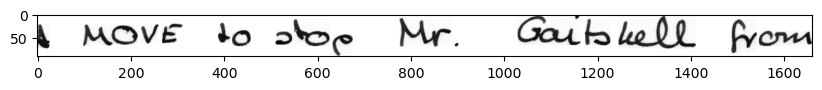

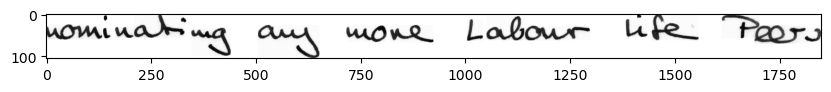

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

for file_name in img_files[:2]:
    img = mpimg.imread(file_name)
    plt.figure(figsize = (10,10))
    plt.imshow(img, cmap ='gray')

Encode writers with a value between 0 and ``n_classes-1``:

In [11]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoded_img_targets = encoder.fit_transform(img_targets)

print("Writer ID        : ", img_targets[:2])
print("Encoded writer ID: ", encoded_img_targets[:2])

Writer ID        :  ['000' '000']
Encoded writer ID:  [0 0]


Split dataset into train, validation, and tests sets:

In [12]:
from sklearn.model_selection import train_test_split

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(img_files, encoded_img_targets, test_size=0.2, shuffle = True)

# Further split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = True)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(3141,) (786,) (982,)
(3141,) (786,) (982,)


Define a couple of constants that will be used throughout the model:

In [13]:
CROP_SIZE = 113
NUM_LABELS = 50
BATCH_SIZE = 16

As suggested in the paper, the input to the model are not unique sentences but rather random patches cropped from each sentence. The ``get_augmented_sample`` method is in charge of doing so by resizing each sentence's height to ``113`` pixels, and its width such that original aspect ratio is maintained. Finally, from the resized image, patches of ``113x113`` are randomly cropped.

In [14]:
from sklearn.utils import shuffle
from PIL import Image
import random

def get_augmented_sample(sample, label, sample_ratio):
    # Get current image details
    img = Image.open(sample)
    img_width = img.size[0]
    img_height = img.size[1]

    # Compute resize dimensions such that aspect ratio is maintained
    height_fac = CROP_SIZE / img_height
    size = (int(img_width * height_fac), CROP_SIZE)

    # Resize image 
    new_img = img.resize(size, Image.LANCZOS)
    new_img_width = new_img.size[0]
    new_img_height = new_img.size[1]

    # Generate a random number of crops of size 113x113 from the resized image
    x_coord = list(range(0, new_img_width - CROP_SIZE))
    num_crops = int(len(x_coord) * sample_ratio)
    random_x_coord = random.sample(x_coord, num_crops)
    
    # Create augmented images (cropped forms) and map them to a label (writer)
    images = []
    labels = []
    for x in random_x_coord:
        img_crop = new_img.crop((x, 0, x + CROP_SIZE, CROP_SIZE))
        # Transform image to an array of numbers
        images.append(np.asarray(img_crop))
        labels.append(label)

    return (images, labels)

Let's visualize what the ``get_augmented_sample`` method does by augmenting one sample from the training set. Let's first take a look at how the original image looks like:

Label:  42


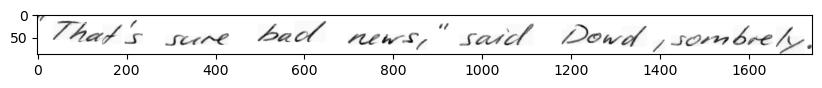

In [15]:
sample, label = X_train[0], y_train[0]
img = mpimg.imread(sample)
plt.figure(figsize = (10,10))
plt.imshow(img, cmap ='gray')
print("Label: ", label)

A now, let's augment it and see the result:

In [16]:
images, labels = get_augmented_sample(sample, label, 0.1)

The ``labels`` returned by the ``get_augmented_sample`` is simply the label of the original image for each cropped patch:

In [17]:
print(labels)
print("Num of labels: ", len(labels))

[42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42]
Num of labels:  212


And the ``images`` returned by it are the random patches created from the original image (only two samples shown for simplicity):

212


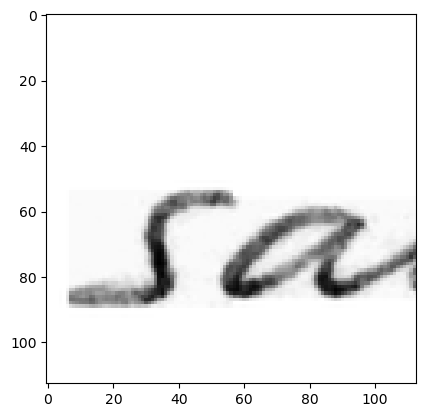

In [18]:
print(len(images))
plt.imshow(images[0], cmap ='gray')

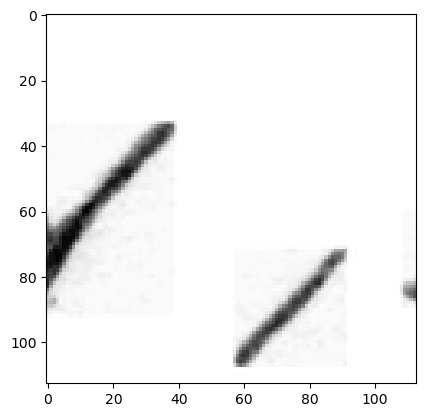

In [19]:
plt.imshow(images[1], cmap ='gray')

The model uses a generator in order to be able to call ``get_augmented_sample`` when training the model:

In [20]:
import operator
from functools import reduce
from keras.utils import to_categorical

def generate_data(samples, labels, batch_size, sample_ratio):
    while 1: 
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset:(offset + batch_size)]
            batch_labels = labels[offset:(offset + batch_size)]
            
            # Augment each sample in batch
            augmented_batch_samples = []
            augmented_batch_labels = []
            for i in range(len(batch_samples)):
                sample = batch_samples[i]
                label = batch_labels[i]
                augmented_samples, augmented_labels = get_augmented_sample(sample, label, sample_ratio)
                augmented_batch_samples.append(augmented_samples)
                augmented_batch_labels.append(augmented_labels)

            # Flatten out samples and labels
            augmented_batch_samples = reduce(operator.add, augmented_batch_samples)
            augmented_batch_labels = reduce(operator.add, augmented_batch_labels)
            
            # Reshape input format
            X_train = np.array(augmented_batch_samples)
            X_train = X_train.reshape(X_train.shape[0], CROP_SIZE, CROP_SIZE, 1)

            # Transform input to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            # Encode y
            y_train = np.array(augmented_batch_labels)
            y_train = to_categorical(y_train, NUM_LABELS)

            yield X_train, y_train

Create training, validation, and test generators:

In [21]:
train_generator = generate_data(X_train, y_train, BATCH_SIZE, 0.3)
validation_generator = generate_data(X_val, y_val, BATCH_SIZE, 0.3)
test_generator = generate_data(X_test, y_test, BATCH_SIZE, 0.1)

In [22]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [23]:
def resize_image(img):
    size = round(CROP_SIZE/2)
    return tf.image.resize(img, [size, size])

The model used is exactly the same as the one in the "[handwriting_recognition](https://github.com/priya-dwivedi/Deep-Learning/tree/master/handwriting_recognition)" notebook by [Priyanka Dwivedi](https://github.com/priya-dwivedi):

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import Adam
from keras import metrics

model = Sequential()

# Define network input shape
model.add(ZeroPadding2D((1, 1), input_shape=(CROP_SIZE, CROP_SIZE, 1)))
# Resize images to allow for easy computation
model.add(Lambda(resize_image))

# CNN model - Building the model suggested in paper
model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2, 2), padding='same', name='conv1'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3, 3), strides= (1, 1), padding='same', name='conv2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2'))

model.add(Convolution2D(filters= 128, kernel_size =(3, 3), strides= (1, 1), padding='same', name='conv3'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(NUM_LABELS, name='output'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 115, 115, 1)      0         
 2D)                                                             
                                                                 
 lambda (Lambda)             (None, 56, 56, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 32)        832       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 14, 14, 64)        18496     
                                                        

Next, the model is trained for 20 epochs and the models obtained after each epoch are saved to the ``./model_checkpoints`` directory

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

# Create directory to save checkpoints at
model_checkpoints_path = "./model_checkpoints"
if not os.path.exists(model_checkpoints_path):
    os.makedirs(model_checkpoints_path)

# Save model after every epoch using checkpoints
create_checkpoint = ModelCheckpoint(
    filepath="./model_checkpoints/check_{epoch:02d}_{val_loss:.4f}.hdf5",
    verbose=1,
    save_best_only=False
)

# Early stopping to stop the training if the validation loss does not improve for 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Fit model using generators
history_object = model.fit(
    train_generator,
    steps_per_epoch=round(len(X_train) / BATCH_SIZE),
    validation_data=validation_generator,
    validation_steps=round(len(X_val) / BATCH_SIZE),
    epochs=20,
    verbose=1,
    callbacks=[create_checkpoint, early_stopping]
)

Epoch 1/20
196/196 [==============================] - ETA: 0s - loss: 3.5636 - acc: 0.2091
Epoch 1: saving model to ./model_checkpoints\check_01_3.2259.hdf5
196/196 [==============================] - 306s 2s/step - loss: 3.5636 - acc: 0.2091 - val_loss: 3.2259 - val_acc: 0.2204
Epoch 2/20
196/196 [==============================] - ETA: 0s - loss: 2.9660 - acc: 0.2447
Epoch 2: saving model to ./model_checkpoints\check_02_2.5765.hdf5
196/196 [==============================] - 338s 2s/step - loss: 2.9660 - acc: 0.2447 - val_loss: 2.5765 - val_acc: 0.2938
Epoch 3/20
196/196 [==============================] - ETA: 0s - loss: 2.4971 - acc: 0.3057
Epoch 3: saving model to ./model_checkpoints\check_03_2.1167.hdf5
196/196 [==============================] - 334s 2s/step - loss: 2.4971 - acc: 0.3057 - val_loss: 2.1167 - val_acc: 0.3830
Epoch 4/20
196/196 [==============================] - ETA: 0s - loss: 2.1790 - acc: 0.3727
Epoch 4: saving model to ./model_checkpoints\check_04_1.8242.hdf5
196/19

Save weights

In [31]:
# Save only the model's weights
model.save_weights('my_model_weights.h5')

Load a saved model weights and use them to predict labels in the test set:

In [36]:
model_weights_path = "./my_model_weights.h5"
if model_weights_path:
    model.load_weights(model_weights_path)
    scores = model.evaluate(test_generator, steps=round(len(X_test)/BATCH_SIZE))
    print("Accuracy: ", scores[1])
else:
    print("Set model weights file to load in the 'model_weights_path' variable")

61/61 [==============================] - 22s 363ms/step - loss: 0.9271 - acc: 0.7130
Accuracy:  0.7130382061004639


Save Model

In [34]:
model.save('my_model.h5')

Evaluate Model

In [40]:
from keras.models import load_model

# Path to the saved entire model
model_path = "./my_model.h5"

if model_path:
    # Load the entire saved model
    model = load_model(model_path)
    
    # Evaluate the model using the test generator
    scores = model.evaluate(test_generator, steps=round(len(X_test)/BATCH_SIZE))
    
    print("Accuracy: ", scores[1])
else:
    print("Set model file to load in the 'model_path' variable")


61/61 [==============================] - 21s 339ms/step - loss: 0.9297 - acc: 0.7133
Accuracy:  0.71332186460495


### Train the Autoencoder

In [45]:
def autoencoder_data_generator(samples, batch_size):
    while 1: 
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset:offset + batch_size]
            
            images = []
            for sample in batch_samples:
                img = Image.open(sample)
                img = img.resize((113, 113))  # Resize to your input size
                img_array = np.asarray(img)
                images.append(img_array)
            
            X_train = np.array(images)
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            X_train = X_train.astype('float32')
            X_train /= 255
            
            yield X_train, X_train  # x and y are the same for an autoencoder

# Create autoencoder data generators
autoencoder_train_generator = autoencoder_data_generator(X_train, 16)
autoencoder_val_generator = autoencoder_data_generator(X_val, 16)

# Now you can use these in your autoencoder training:
autoencoder.fit(autoencoder_train_generator, epochs=50, 
                steps_per_epoch=len(X_train) // 16,
                validation_data=autoencoder_val_generator,
                validation_steps=len(X_val) // 16)


Epoch 1/50
196/196 [==============================] - 14s 70ms/step - loss: 0.2652 - val_loss: 0.2503
Epoch 2/50
196/196 [==============================] - 13s 69ms/step - loss: 0.2452 - val_loss: 0.2412
Epoch 3/50
196/196 [==============================] - 13s 68ms/step - loss: 0.2399 - val_loss: 0.2388
Epoch 4/50
196/196 [==============================] - 13s 68ms/step - loss: 0.2377 - val_loss: 0.2372
Epoch 5/50
196/196 [==============================] - 13s 67ms/step - loss: 0.2370 - val_loss: 0.2378
Epoch 6/50
196/196 [==============================] - 13s 68ms/step - loss: 0.2366 - val_loss: 0.2365
Epoch 7/50
196/196 [==============================] - 14s 72ms/step - loss: 0.2362 - val_loss: 0.2367
Epoch 8/50
196/196 [==============================] - 14s 70ms/step - loss: 0.2359 - val_loss: 0.2364
Epoch 9/50
196/196 [==============================] - 14s 70ms/step - loss: 0.2353 - val_loss: 0.2354
Epoch 10/50
196/196 [==============================] - 13s 64ms/step - loss: 0.234

In [47]:
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model

# Assuming each image has a shape of (113, 113, 1)
input_shape = (113, 113, 1)
encoding_dim = 64  # size of the encoded representations

# Encoder
input_img = Input(shape=input_shape)
flattened = Flatten()(input_img)
encoded = Dense(encoding_dim, activation='relu')(flattened)

# Decoder
decoded = Dense(np.prod(input_shape), activation='sigmoid')(encoded)
decoded = Reshape(input_shape)(decoded)

# Full autoencoder model
autoencoder = Model(input_img, decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# You may need to adjust your data generators to work with the autoencoder.
# For now, I'm assuming you have suitable `autoencoder_train_generator` and `autoencoder_val_generator`.
autoencoder.fit(autoencoder_train_generator, epochs=50, 
                steps_per_epoch=len(X_train) // 16,
                validation_data=autoencoder_val_generator,
                validation_steps=len(X_val) // 16)

Epoch 1/50
196/196 [==============================] - 14s 70ms/step - loss: 0.2668 - val_loss: 0.2528
Epoch 2/50
196/196 [==============================] - 14s 69ms/step - loss: 0.2491 - val_loss: 0.2478
Epoch 3/50
196/196 [==============================] - 13s 68ms/step - loss: 0.2425 - val_loss: 0.2401
Epoch 4/50
196/196 [==============================] - 13s 68ms/step - loss: 0.2385 - val_loss: 0.2375
Epoch 5/50
196/196 [==============================] - 14s 70ms/step - loss: 0.2371 - val_loss: 0.2370
Epoch 6/50
196/196 [==============================] - 14s 71ms/step - loss: 0.2365 - val_loss: 0.2370
Epoch 7/50
196/196 [==============================] - 14s 70ms/step - loss: 0.2365 - val_loss: 0.2368
Epoch 8/50
196/196 [==============================] - 14s 71ms/step - loss: 0.2362 - val_loss: 0.2368
Epoch 9/50
196/196 [==============================] - 14s 72ms/step - loss: 0.2359 - val_loss: 0.2364
Epoch 10/50
196/196 [==============================] - 14s 69ms/step - loss: 0.235

### Extract the Encoder

In [56]:
# Encoder model for feature extraction
encoder = Model(input_img, encoded)

In [60]:
from collections import defaultdict
import numpy as np

writer_centroids = defaultdict(list)

# Loop through each writer's images
for writer_id in top_writers:  # Assuming top_writers contains the writer IDs
    writer_images = []  # Collect all images for this writer
    for form_id, writer in form_writer.items():
        if writer == writer_id:
            image_path = os.path.join(temp_sentences_path, form_id + '.png')  # Adjust as needed
            image = Image.open("../data/a01-043u-s04-03.png")
            image = image.resize((113, 113))
            writer_images.append(np.asarray(image))
            
    writer_images = np.array(writer_images).reshape(len(writer_images), 113, 113, 1)
    encoded_images = encoder.predict(writer_images)
    centroid = np.mean(encoded_images, axis=0)
    writer_centroids[writer_id] = centroid


1/1 [==============================] - 0s 20ms/step


In [62]:
writer_thresholds = {}

for writer_id, centroid in writer_centroids.items():
    writer_images = []  # Collect all images for this writer
    for form_id, writer in form_writer.items():
        if writer == writer_id:
            image_path = os.path.join(temp_sentences_path, form_id + '.png')  # Adjust as needed
            image = Image.open("../data/a01-043u-s04-03.png")
            image = image.resize((113, 113))
            writer_images.append(np.asarray(image))
            
    writer_images = np.array(writer_images).reshape(len(writer_images), 113, 113, 1)
    encoded_images = encoder.predict(writer_images)
    distances = [np.linalg.norm(encoded - centroid) for encoded in encoded_images]
    avg_distance = np.mean(distances)
    writer_thresholds[writer_id] = avg_distance * 1.2  # Adding some margin


1/1 [==============================] - 0s 24ms/step


In [65]:
def identify_writer(new_image, writer_centroids, writer_thresholds):
    # Preprocess the new image and encode it
    new_image = Image.open(new_image).resize((113, 113))
    new_image = np.asarray(new_image).reshape(1, 113, 113, 1)
    encoded_image = encoder.predict(new_image)

    for writer_id, centroid in writer_centroids.items():
        distance = np.linalg.norm(encoded_image - centroid)
        if distance < writer_thresholds[writer_id]:
            print(f"Writer identified as {writer_id}")
            return writer_id

    print("This is a new writer.")
    return None


### Anomaly Detection for New Class

In [50]:
# Assume you have some 'normal_data_points' and one 'new_data_point'
normal_data_points = np.random.rand(100, 113, 113, 1)  # Replace with your actual normal data
new_data_point = np.random.rand(1, 113, 113, 1)  # Replace with your actual new data point

# Encode the normal data points to get their latent space representations
encoded_normal_data_points = encoder.predict(normal_data_points)

# Encode the new data point to get its latent space representation
encoded_new_data_point = encoder.predict(new_data_point)

# Calculate the centroid of the normal data points in the latent space
centroid = np.mean(encoded_normal_data_points, axis=0)

# Calculate the distance between the new data point and the centroid
distance = np.linalg.norm(encoded_new_data_point - centroid)

# Define a threshold for anomaly detection (this should be based on your specific case)
threshold = 10.0

# Detect if the new data point is an anomaly
if distance > threshold:
    print("Anomaly detected")
else:
    print("No anomaly detected")


1/1 [==============================] - 0s 18ms/step
No anomaly detected


### Add new class

In [ ]:
from PIL import Image
import numpy as np

# Step 1: Read the image
img_path = 'path/to/your/test/image.png'  # Replace with the actual path
img = Image.open(img_path)

# Step 2: Resize and preprocess
img = img.resize((CROP_SIZE, CROP_SIZE))  # Replace CROP_SIZE with the actual size
img_array = np.asarray(img)

# Step 3: Expand dimensions to match the input shape
test_data_point = np.expand_dims(img_array, axis=0)  # Makes it (1, CROP_SIZE, CROP_SIZE, num_channels)

# If your images are grayscale and your model expects a single channel image, you might also need to reshape:
test_data_point = test_data_point.reshape(test_data_point.shape[0], CROP_SIZE, CROP_SIZE, 1)

# Normalize the data if your model expects that
test_data_point = test_data_point.astype('float32') / 255.0


### Integrate with Original Classifier

In [55]:
# Assuming original_model and test_data_point are defined and preprocessed
# Define your confidence_threshold
original_model = model
confidence_threshold = 0.8

# Make a prediction with the original classifier
original_prediction = original_model.predict(test_data_point)

# If prediction confidence is low, check for the new class
if max(original_prediction[0]) < confidence_threshold:
    # Encode the test data point to get its latent space representation
    encoded_test_data_point = encoder.predict(test_data_point)
    
    # Calculate the 'difference' based on your specific logic
    # For instance, using Euclidean distance from a centroid
    difference = np.linalg.norm(encoded_test_data_point - centroid)
    
    # Define your 'threshold' for anomaly detection
    threshold = 10.0  # Replace with your actual threshold
    
    # Measure the difference and check against the threshold
    if difference > threshold:
        final_prediction = "new_class"
    else:
        final_prediction = np.argmax(original_prediction)  # or any other way to interpret the prediction
else:
    final_prediction = np.argmax(original_prediction)  # or any other way to interpret the prediction

print("Final Prediction:", final_prediction)


IndexError: tuple index out of range